In [1]:
from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from numpy.linalg import lstsq

In [2]:
# For plotting

def compute_bounds(mu, sig, n_sigma = 3):
    """
    Use mean and standard deviation vectors to compute upper and lower bounds.
    """
    upper = mu + n_sigma * np.sqrt(np.abs(sig))
    lower = mu - n_sigma * np.sqrt(np.abs(sig))
    
    return upper, lower

In [3]:
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig1_bc.hdf5", "r")

#get the data for plotting the sd image
dataCh0 = np.array(f1['dataCh0'])
roimask = np.array(f1['roimask'])
x_zoom = np.array(f1['x_zoom'])

f1.close()

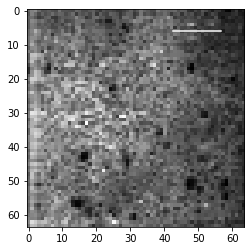

In [4]:
#calculate std and plot std image of field
std = np.std(dataCh0, axis=2)  # standard deviation across time
mean_stack = np.mean(dataCh0, axis=2)

# plt.imshow(std.T, vmax=20, cmap="Greys_r")
plt.imshow(mean_stack.T, origin='upper', cmap='Greys_r')

#scale bar business
total_length = (71.5/x_zoom)
scale_bar_microns = 50
scale_bar_start = 150
plt.axhline(y=6, xmin=scale_bar_start/total_length, xmax=(scale_bar_microns+scale_bar_start)/total_length, color='white')

plt.show()

# Get snippet data

In [5]:
#pull this data from the hdf5 file
data_df = pd.read_hdf('Data/Fig1_bc.hdf5', 'snippet_data_df')

# Plot a localized field average

In [6]:
#mask the dataframe to include the ROIs responding during the time window of the stimulus
mask_start = 1.0
mask_end = 2.0
tpnts = data_df.index.get_level_values('time_bin')
timemask = (tpnts > mask_start) & (tpnts < mask_end)
data_df_masked = data_df.loc[(slice(None), slice(None), slice(None), timemask), :]
data_max = data_df_masked['preprocess_snippets'].groupby(['roi_ids','directions', 'lengths']).max()
# data_max_index = data_df_masked['preprocess_snippets'].groupby(['roi_ids','directions', 'lengths']).idxmax()


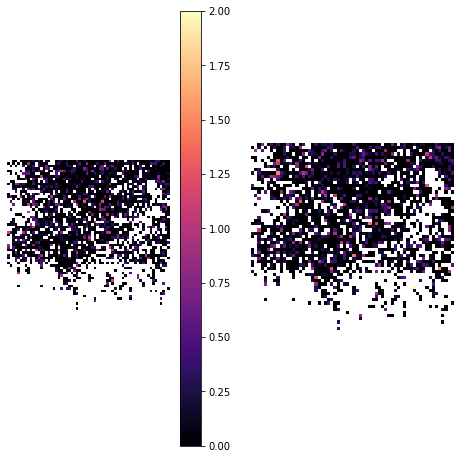

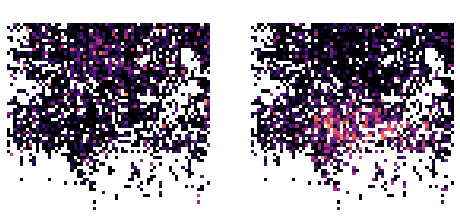

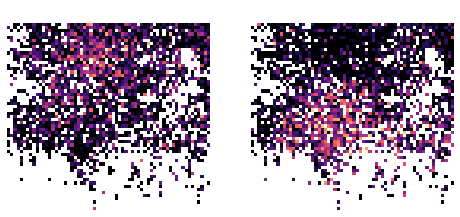

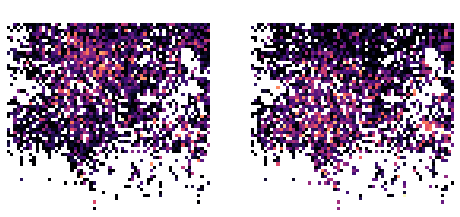

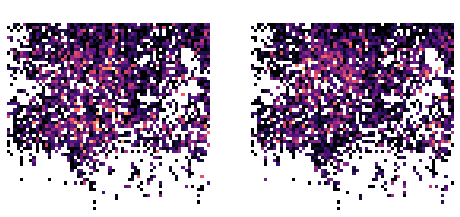

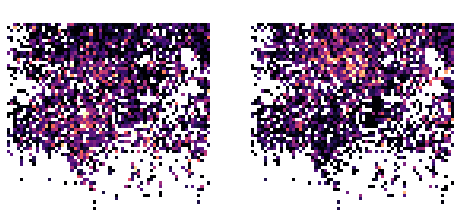

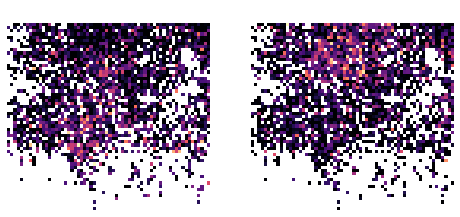

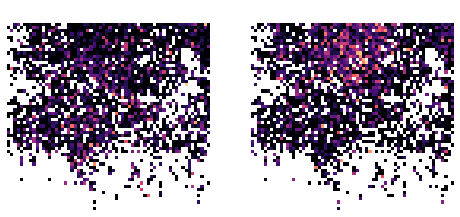

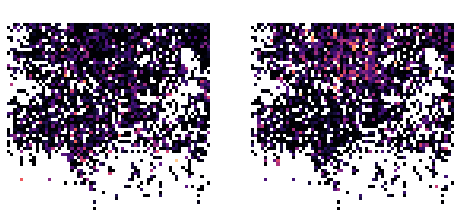

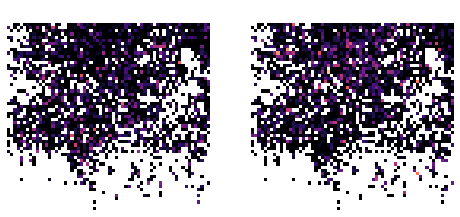

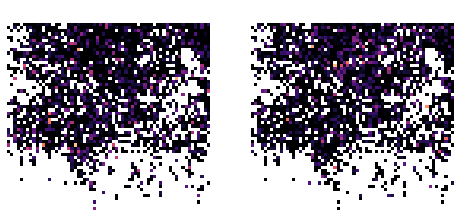

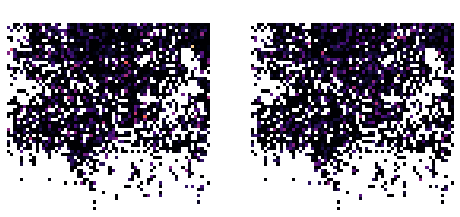

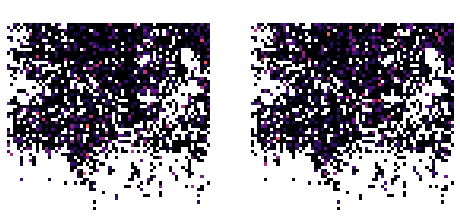

In [7]:
#plot a montage of the responses in the field across time
times = [ 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, ] #1.0, 1.1,
dsmap = roimask*(-1)
for start in times:
    mask_start = start
    mask_end = mask_start+0.05
    tpnts = data_df.index.get_level_values('time_bin')
    timemask = (tpnts > mask_start) & (tpnts < mask_end)
    data_df_masked = data_df.loc[(slice(None), slice(None), slice(None), timemask), :]
    data_mean = data_df_masked['preprocess_snippets'].groupby(['roi_ids','directions', 'lengths']).mean()
    
    xlength = dsmap.shape[0]
    ylength = dsmap.shape[1]
    ds_rois = data_max.index.to_frame(index=False)['roi_ids'].unique()
    
    #make first condition DS mask
    length1 = 100
    direction1 = 180
    dsmap1 = roimask*(-1)
    for x in range(xlength):
        for y in range(ylength):  
            if dsmap1[x,y] in ds_rois:
                roi_index = np.int(dsmap1[x, y])
                dsmap1[x,y] = data_mean.loc[(roi_index, direction1, length1)]
            else:
                dsmap1[x,y] = np.nan
    
    #make first condition DS mask
    length2 = 100
    direction2 = 0
    dsmap2 = roimask*(-1)
    for x in range(xlength):
        for y in range(ylength):  
            if dsmap2[x,y] in ds_rois:
                roi_index = np.int(dsmap2[x, y])
                dsmap2[x,y] = data_mean.loc[(roi_index, direction2, length2)]
            else:
                dsmap2[x,y] = np.nan


    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(1,2,1)
    plt.imshow(dsmap1, cmap='magma', vmin=0.0, vmax=2.)
    ax.set_facecolor('k')
    plt.axis('off')
    if start == 1.1:
        plt.colorbar()
    
    ax = fig.add_subplot(1,2,2)
    plt.imshow(dsmap2, cmap='magma', vmin=0.0, vmax=2.)
    ax.set_facecolor('k')
    plt.axis('off')

    plt.show()

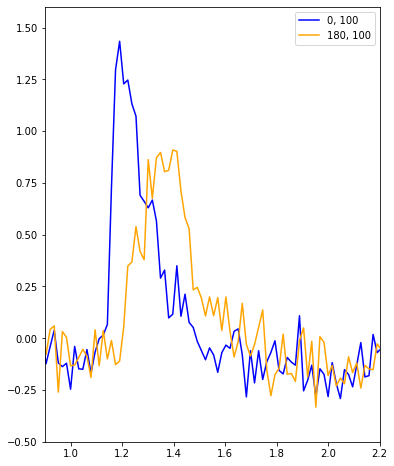

In [8]:
#plot response in a specific part of the field of view
ybottom = 22 
ytop = ybottom+18
xbottom = 32 #responses in box 1
xtop = xbottom+10


rois = []
area = roimask*(-1)
for x in range(xbottom, xtop):
    for y in range(ybottom, ytop):
        if area[x,y]>0:
            rois.append(np.int(area[x,y]))



box_responses = data_df.loc[rois].copy()
mean_responses = box_responses['preprocess_snippets'].mean()
std_responses = box_responses['preprocess_snippets'].std()

box_responses['preprocess_snippets_zscored'] = (box_responses['preprocess_snippets'] - mean_responses)/std_responses

area_means = box_responses.groupby(['directions', 'lengths', 'time_bin']).mean()

plt.figure(figsize=(6, 8))
directions = area_means.index.to_frame(index=False)['directions'].unique()
lengths = area_means.index.to_frame(index=False)['lengths'].unique()
# directions = [0, 180]
lengths = [100]

colors = ['blue', 'orange', 'yellow', 'magenta', 'red', 'green', 'purple', 'black']

index = 1
for direction in directions:
    for length in lengths:

        xval = area_means['preprocess_snippets_zscored'].loc[(direction, length)].index.to_frame(index=False)['time_bin']
        plt.plot(xval, area_means['preprocess_snippets_zscored'].loc[(direction, length)], color=colors[index-1], label=str(direction)+', '+str(length))
        index+=1
plt.legend()
axes = plt.gca()
axes.set_xlim([0.9, 2.2])
axes.set_ylim([-0.5, 1.6])

plt.show()

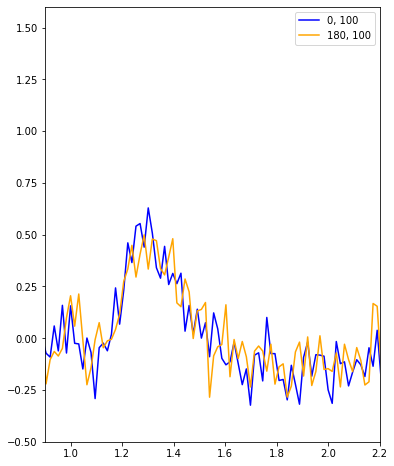

In [9]:
ybottom = 0 
ytop = ybottom+18
xbottom = 26 #responses in box 2
xtop = xbottom+10


rois = []
area = roimask*(-1)
for x in range(xbottom, xtop):
    for y in range(ybottom, ytop):
        if area[x,y]>0:
            rois.append(np.int(area[x,y]))



box_responses = data_df.loc[rois].copy()
mean_responses = box_responses['preprocess_snippets'].mean()
std_responses = box_responses['preprocess_snippets'].std()

box_responses['preprocess_snippets_zscored'] = (box_responses['preprocess_snippets'] - mean_responses)/std_responses

area_means = box_responses.groupby(['directions', 'lengths', 'time_bin']).mean()

plt.figure(figsize=(6, 8))
directions = area_means.index.to_frame(index=False)['directions'].unique()
lengths = area_means.index.to_frame(index=False)['lengths'].unique()
# directions = [0, 180]
lengths = [100]

colors = ['blue', 'orange', 'yellow', 'magenta', 'red', 'green', 'purple', 'black']

index = 1
for direction in directions:
    for length in lengths:

        xval = area_means['preprocess_snippets_zscored'].loc[(direction, length)].index.to_frame(index=False)['time_bin']
        plt.plot(xval, area_means['preprocess_snippets_zscored'].loc[(direction, length)], color=colors[index-1], label=str(direction)+', '+str(length))
        index+=1
plt.legend()
axes = plt.gca()
axes.set_xlim([0.9, 2.2])
axes.set_ylim([-0.5, 1.6])

plt.show()